<a href="https://colab.research.google.com/github/Pathway2008/CarPrice/blob/main/4%2C14%2C15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Nan값을 대체하지 않는 편이 좋아보임, Nan값이여서 가격이 싼 거 일수도
#제조사 별, 모델 별 특징을 찾아보기!

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.font_manager as fm
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
warnings.filterwarnings('ignore')

from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import shap
from scipy.stats import skew, kurtosis

In [3]:
!apt-get -qq install fonts-nanum


fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

Selecting previously unselected package fonts-nanum.
(Reading database ... 123634 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [4]:
train = pd.read_csv('/content/drive/MyDrive/CarPrice/new_car/train.csv')
test = pd.read_csv('/content/drive/MyDrive/CarPrice/new_car/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/CarPrice/new_car/sample_submission.csv')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        7497 non-null   object 
 1   제조사       7497 non-null   object 
 2   모델        7497 non-null   object 
 3   차량상태      7497 non-null   object 
 4   배터리용량     4786 non-null   float64
 5   구동방식      7497 non-null   object 
 6   주행거리(km)  7497 non-null   int64  
 7   보증기간(년)   7497 non-null   int64  
 8   사고이력      7497 non-null   object 
 9   연식(년)     7497 non-null   int64  
 10  가격(백만원)   7497 non-null   float64
dtypes: float64(2), int64(3), object(6)
memory usage: 644.4+ KB


In [5]:
def describe_statistics(column):
    stats = pd.DataFrame({
        'mean': [column.mean()],
        'sd': [column.std()],
        'median': [column.median()],
        'trimmed': [column[(column > column.quantile(0.05)) & (column < column.quantile(0.95))].mean()],
        # 'mad': [column.mad()],
        'min': [column.min()],
        'max': [column.max()],
        'range': [column.max() - column.min()],
        'skew': [skew(column)],
        'kurtosis': [kurtosis(column)],
        'se': [column.std() / np.sqrt(len(column))]
    })
    return stats

In [13]:
des_price = describe_statistics(train['가격(백만원)'])

In [14]:
des_price

,mean,sd,median,trimmed,min,max,range,skew,kurtosis,se
0,62.331949,36.646759,56.0,59.383758,9.0,161.09,152.09,1.003136,0.356971,0.423245


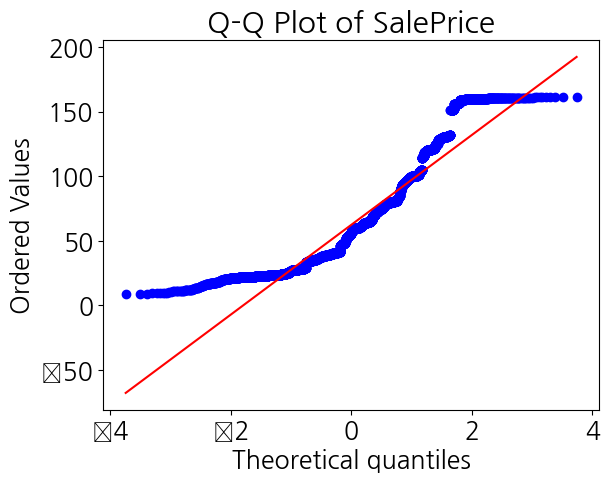

In [48]:
stats.probplot(train['가격(백만원)'], dist="norm", plot=plt)
plt.title('Q-Q Plot of SalePrice')
plt.show()

In [49]:
from scipy.stats import shapiro, kstest
# Shapiro-Wilk Test
stat, p = shapiro(train['가격(백만원)'].dropna())
print('Shapiro-Wilk Test: stat=%.3f, p=%.3f' % (stat, p))
#total 가격은 정규분포를 따르지 않

Shapiro-Wilk Test: stat=0.899, p=0.000


In [50]:
# stat, p = kstest(train['가격(백만원)'], 'norm')
# print('Kolmogorov-Smirnov Test: stat=%.3f, p=%.3f' % (stat, p))

Kolmogorov-Smirnov Test: stat=1.000, p=0.000


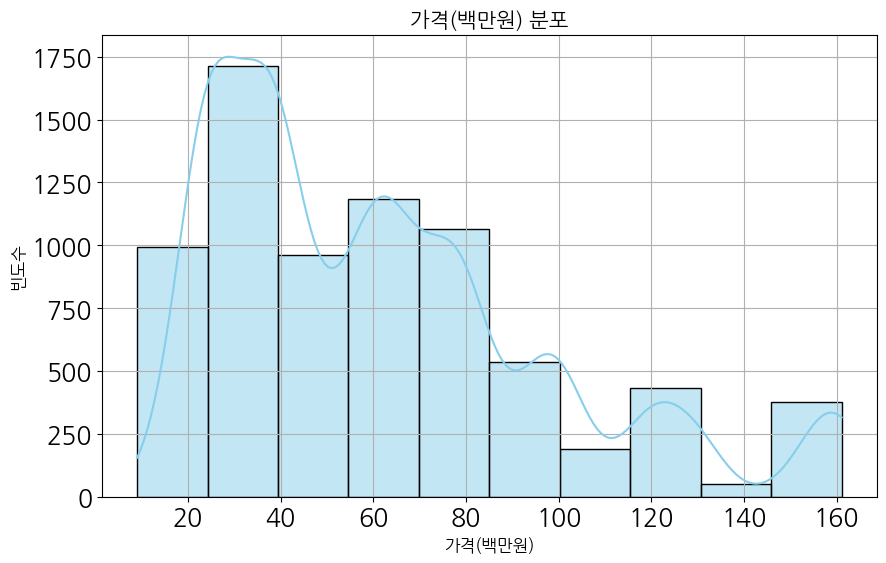

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(train['가격(백만원)'], kde=True, bins=10, color='skyblue')

# 제목과 축 레이블 추가
plt.title('가격(백만원) 분포', fontsize=15)
plt.xlabel('가격(백만원)', fontsize=12)
plt.ylabel('빈도수', fontsize=12)

# 그래프 표시
plt.grid(True)
plt.show()

In [17]:
train.select_dtypes(exclude='object').corr()

,배터리용량,주행거리(km),보증기간(년),연식(년),가격(백만원)
배터리용량,1.000000,-0.576538,0.558242,-0.021845,0.431668
주행거리(km),-0.576538,1.000000,-0.664071,-0.089586,-0.035488
보증기간(년),0.558242,-0.664071,1.000000,0.035294,-0.349962
연식(년),-0.021845,-0.089586,0.035294,1.000000,-0.058455
가격(백만원),0.431668,-0.035488,-0.349962,-0.058455,1.000000


In [ ]:
# IONIQ

In [24]:
des_ioniq = describe_statistics(train[train['모델']=='IONIQ']['가격(백만원)'])
des_ioniq

,mean,sd,median,trimmed,min,max,range,skew,kurtosis,se
0,17.9915,5.421621,17.895,17.971349,9.0,27.53,18.53,0.042206,-1.284068,0.458211


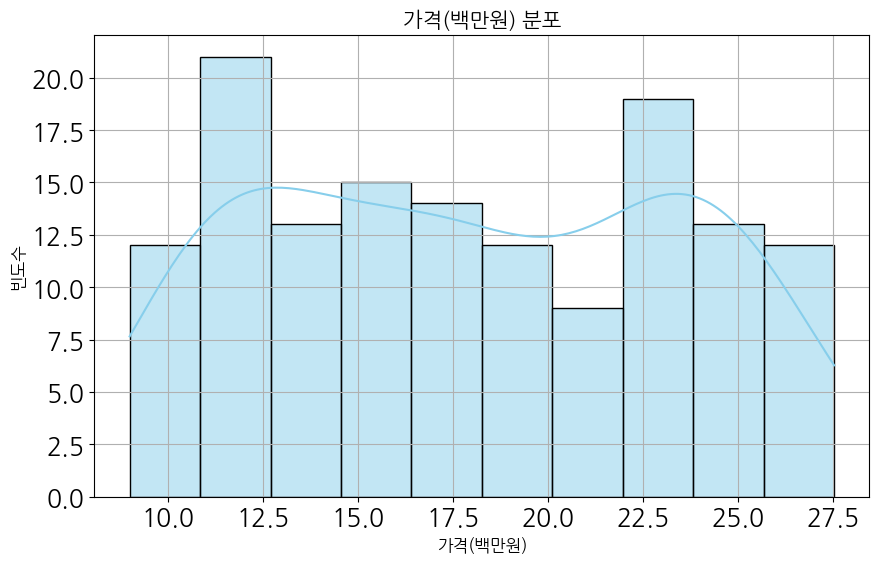

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(train[train['모델']=='IONIQ']['가격(백만원)'], kde=True, bins=10, color='skyblue')

# 제목과 축 레이블 추가
plt.title('가격(백만원) 분포', fontsize=15)
plt.xlabel('가격(백만원)', fontsize=12)
plt.ylabel('빈도수', fontsize=12)

# 그래프 표시
plt.grid(True)
plt.show()

In [28]:
des_tay = describe_statistics(train[train['모델']=='Tay']['가격(백만원)'])
des_tay

,mean,sd,median,trimmed,min,max,range,skew,kurtosis,se
0,109.932188,10.041671,114.4,110.098669,95.0,122.07,27.07,-0.237381,-1.598243,0.528509


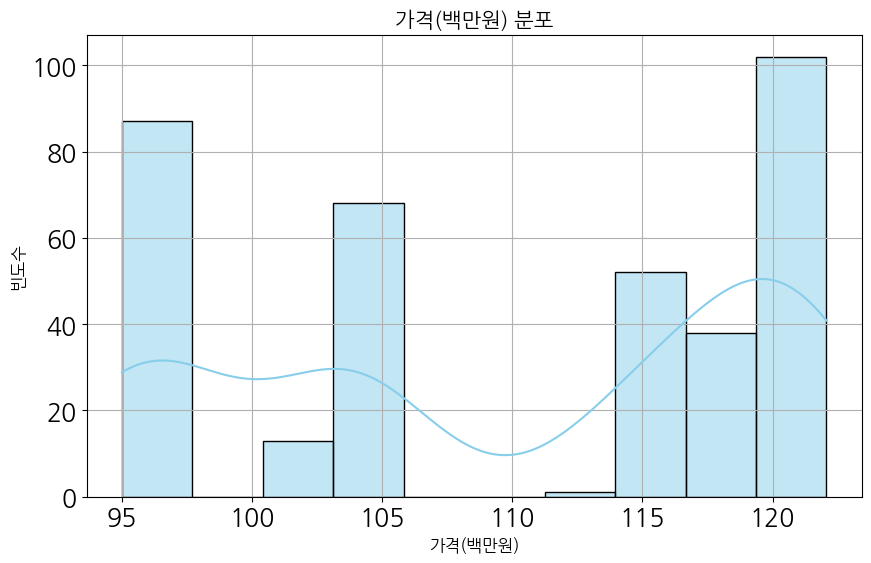

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(train[train['모델']=='Tay']['가격(백만원)'], kde=True, bins=10, color='skyblue')

# 제목과 축 레이블 추가
plt.title('가격(백만원) 분포', fontsize=15)
plt.xlabel('가격(백만원)', fontsize=12)
plt.ylabel('빈도수', fontsize=12)

# 그래프 표시
plt.grid(True)
plt.show()

In [30]:
des_tayct = describe_statistics(train[train['모델']=='TayCT']['가격(백만원)'])
des_tayct

,mean,sd,median,trimmed,min,max,range,skew,kurtosis,se
0,126.312657,4.484444,128.2,126.4467,119.0,132.0,13.0,-0.456964,-1.424996,0.245011


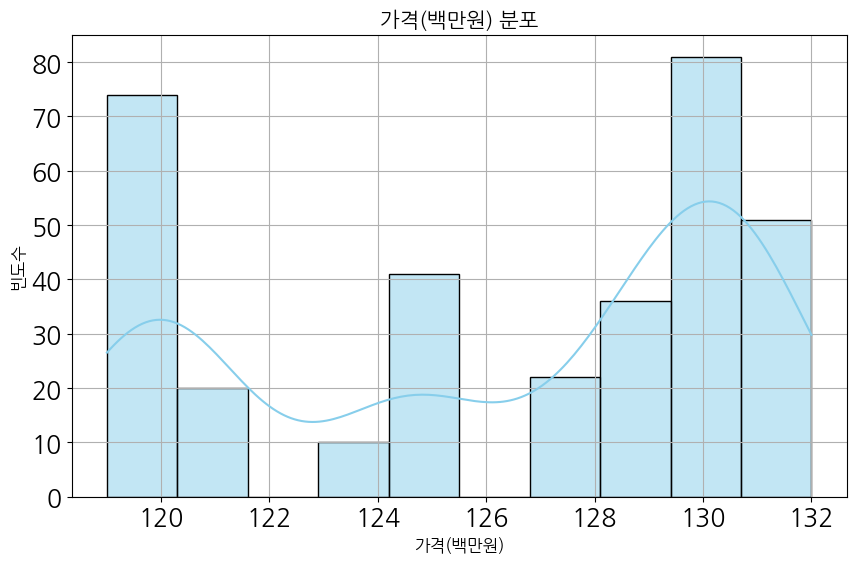

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(train[train['모델']=='TayCT']['가격(백만원)'], kde=True, bins=10, color='skyblue')

# 제목과 축 레이블 추가
plt.title('가격(백만원) 분포', fontsize=15)
plt.xlabel('가격(백만원)', fontsize=12)
plt.ylabel('빈도수', fontsize=12)

# 그래프 표시
plt.grid(True)
plt.show()

In [32]:
print('IONIQ')
display(train[train['모델']=='IONIQ'].select_dtypes(exclude='object').corr())
print('Tay')
display(train[train['모델']=='Tay'].select_dtypes(exclude='object').corr())
print('TayCT')
display(train[train['모델']=='TayCT'].select_dtypes(exclude='object').corr())

IONIQ


,배터리용량,주행거리(km),보증기간(년),연식(년),가격(백만원)
배터리용량,1.000000,0.040190,0.042917,-0.097879,0.035659
주행거리(km),0.040190,1.000000,0.019544,0.006395,0.057235
보증기간(년),0.042917,0.019544,1.000000,0.037115,0.099766
연식(년),-0.097879,0.006395,0.037115,1.000000,0.056723
가격(백만원),0.035659,0.057235,0.099766,0.056723,1.000000


Tay


,배터리용량,주행거리(km),보증기간(년),연식(년),가격(백만원)
배터리용량,1.000000,-0.725926,-0.209287,0.209287,-0.630803
주행거리(km),-0.725926,1.000000,0.080813,-0.080813,0.507819
보증기간(년),-0.209287,0.080813,1.000000,-1.000000,-0.400984
연식(년),0.209287,-0.080813,-1.000000,1.000000,0.400984
가격(백만원),-0.630803,0.507819,-0.400984,0.400984,1.000000


TayCT


,배터리용량,주행거리(km),보증기간(년),연식(년),가격(백만원)
배터리용량,1.000000,-0.389641,0.183851,-0.183851,-0.090239
주행거리(km),-0.389641,1.000000,0.104303,-0.104303,0.024681
보증기간(년),0.183851,0.104303,1.000000,-1.000000,0.329984
연식(년),-0.183851,-0.104303,-1.000000,1.000000,-0.329984
가격(백만원),-0.090239,0.024681,0.329984,-0.329984,1.000000


In [52]:
from scipy.stats import shapiro, kstest
# Shapiro-Wilk Test
stat, p1 = shapiro(train[train['모델']==4]['가격(백만원)'].dropna())
stat, p2 = shapiro(train[train['모델']==14]['가격(백만원)'].dropna())
stat, p3 = shapiro(train[train['모델']==15]['가격(백만원)'].dropna())
p1,p2,p3

(2.7780297061854704e-05, 1.1035582147001192e-18, 8.9498742472551e-18)

In [53]:
log_4 = np.log1p(train[train['모델']==4]['가격(백만원)'].dropna())
log_14 = np.log1p(train[train['모델']==14]['가격(백만원)'].dropna())
log_15 = np.log1p(train[train['모델']==15]['가격(백만원)'].dropna())

stat, p1 = shapiro(log_4)
stat, p2 = shapiro(log_14)
stat, p3 = shapiro(log_15)
p1,p2,p3

(1.4710307384472008e-05, 8.018141939309075e-19, 6.151758652514077e-18)

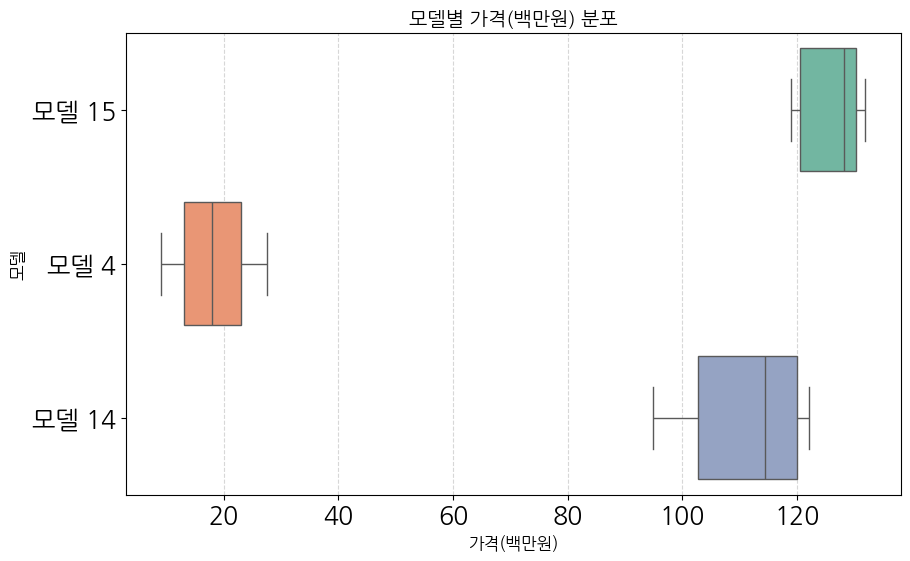

In [55]:
filtered_data = train[train['모델'].isin([4, 14, 15])]
filtered_data['모델명'] = filtered_data['모델'].replace({4: '모델 4', 14: '모델 14', 15: '모델 15'})

# 박스플롯 생성
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_data, x='가격(백만원)', y='모델명', palette='Set2')

# 그래프 개선
plt.title('모델별 가격(백만원) 분포', fontsize=14)
plt.xlabel('가격(백만원)', fontsize=12)
plt.ylabel('모델', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

In [ ]:
import pandas as pd

# IONIQ 모델 필터링
ioniq_data = train[train['모델'] == 4]

# '가격(백만원)' 컬럼만 추출
prices = ioniq_data['가격(백만원)']

# IQR 계산
Q1 = prices.quantile(0.25)  # 1사분위수
Q3 = prices.quantile(0.75)  # 3사분위수
IQR = Q3 - Q1  # IQR

# 이상치 범위 설정
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 탐지
outliers = prices[(prices < lower_bound) | (prices > upper_bound)]

# 이상치 출력
print(f"이상치 개수: {outliers.shape[0]}")
print(f"이상치 값들:\n{outliers}")

In [ ]:
from scipy.stats import zscore

# '가격(백만원)' 컬럼의 Z-Score 계산
prices_zscore = zscore(ioniq_data['가격(백만원)'])

# Z-Score가 3보다 큰 값은 이상치
outliers_zscore = ioniq_data['가격(백만원)'][abs(prices_zscore) > 3]

# 이상치 출력
print(f"이상치 개수 (Z-Score): {outliers_zscore.shape[0]}")
print(f"이상치 값들 (Z-Score):\n{outliers_zscore}")

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        7497 non-null   object 
 1   제조사       7497 non-null   object 
 2   모델        7497 non-null   object 
 3   차량상태      7497 non-null   object 
 4   배터리용량     4786 non-null   float64
 5   구동방식      7497 non-null   object 
 6   주행거리(km)  7497 non-null   int64  
 7   보증기간(년)   7497 non-null   int64  
 8   사고이력      7497 non-null   object 
 9   연식(년)     7497 non-null   int64  
 10  가격(백만원)   7497 non-null   float64
dtypes: float64(2), int64(3), object(6)
memory usage: 644.4+ KB


In [6]:
ordinal_features = ['제조사', '차량상태', '구동방식','사고이력',  '모델']
mappings = {}

for feature in ordinal_features:
    le = LabelEncoder()
    le = le.fit(train[feature])
    train[feature] = le.transform(train[feature])
    mappings[feature] = dict(zip(le.classes_, le.transform(le.classes_)))

    for label in np.unique(test[feature]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test[feature] = le.transform(test[feature])

In [7]:
for feature, mapping in mappings.items():
    print(f"{feature} Mapping:")
    for key, value in mapping.items():
        print(f"'{key}' -> {value}")
    print()

제조사 Mapping:
'A사' -> 0
'B사' -> 1
'H사' -> 2
'K사' -> 3
'P사' -> 4
'T사' -> 5
'V사' -> 6

차량상태 Mapping:
'Brand New' -> 0
'Nearly New' -> 1
'Pre-Owned' -> 2

구동방식 Mapping:
'AWD' -> 0
'FWD' -> 1
'RWD' -> 2

사고이력 Mapping:
'No' -> 0
'Yes' -> 1

모델 Mapping:
'EV6' -> 0
'ID4' -> 1
'ION5' -> 2
'ION6' -> 3
'IONIQ' -> 4
'KNE' -> 5
'M3' -> 6
'MS' -> 7
'MX' -> 8
'MY' -> 9
'Niro' -> 10
'Q4eT' -> 11
'RSeTGT' -> 12
'Soul' -> 13
'Tay' -> 14
'TayCT' -> 15
'TayGTS' -> 16
'eT' -> 17
'i3' -> 18
'i5' -> 19
'iX' -> 20



In [43]:
ioniq_data = train[train['모델'] == 4]

X = ioniq_data.drop(['ID', '제조사', '모델', '가격(백만원)'], axis=1)
y = ioniq_data['가격(백만원)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=43)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

6.172391815589179

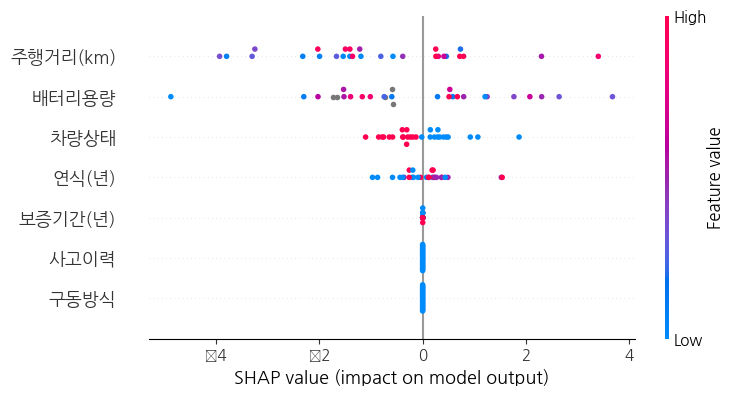

In [44]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# SHAP summary plot
shap.summary_plot(shap_values, X_test)

In [57]:
ioniq_data = train[train['모델'] == 4]

X = ioniq_data.drop(['ID', '제조사', '모델', '가격(백만원)','보증기간(년)','사고이력','구동방식'], axis=1)
y = ioniq_data['가격(백만원)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=43)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

6.184278163699793

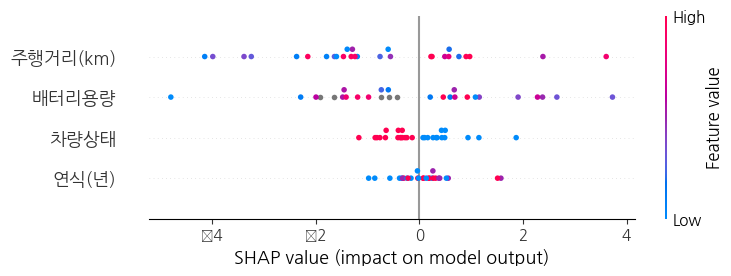

In [58]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# SHAP summary plot
shap.summary_plot(shap_values, X_test)

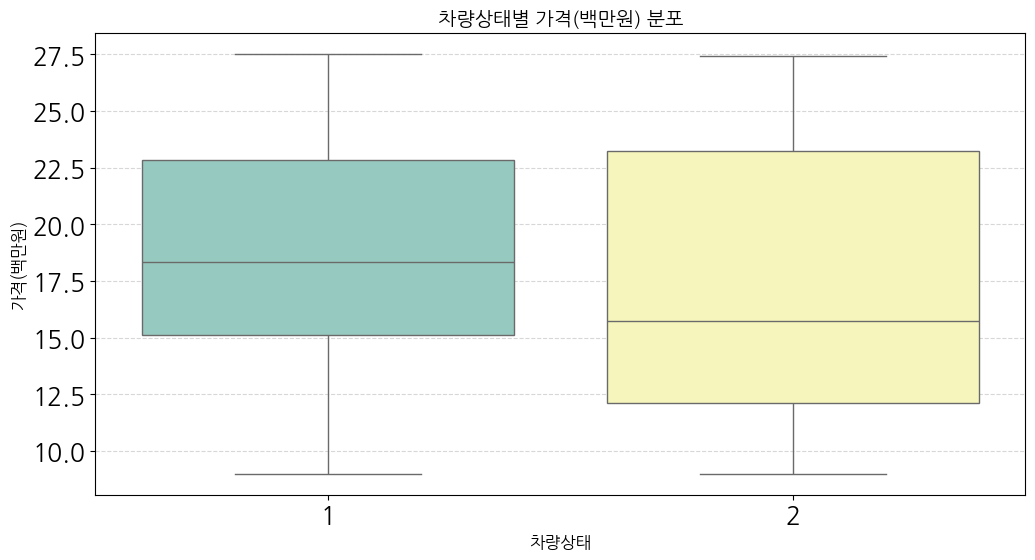

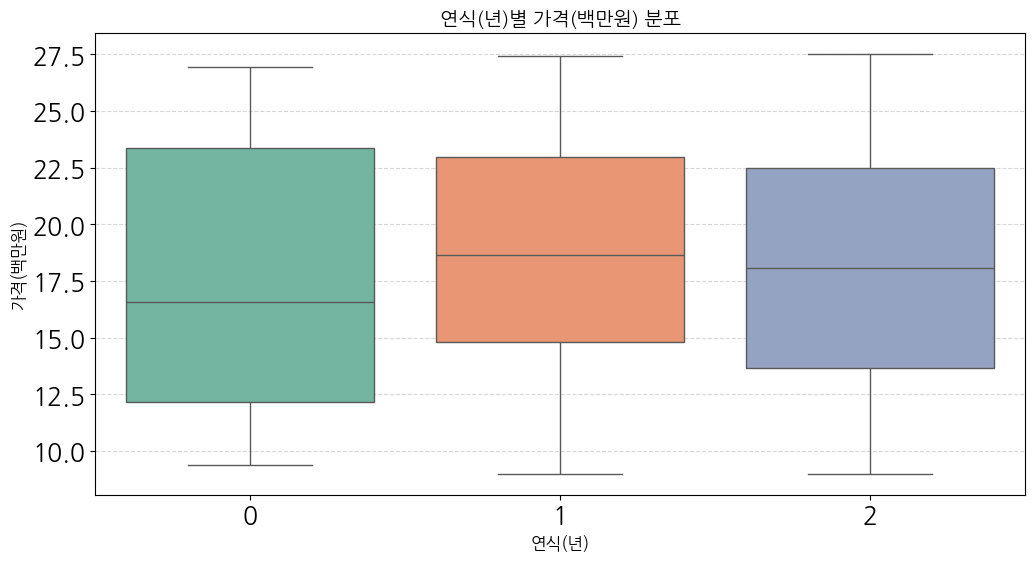

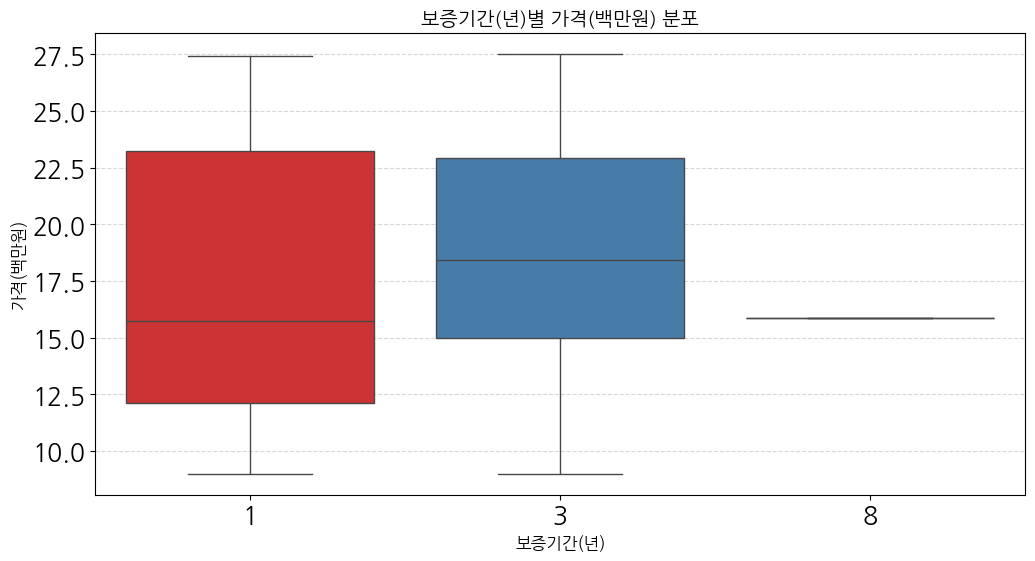

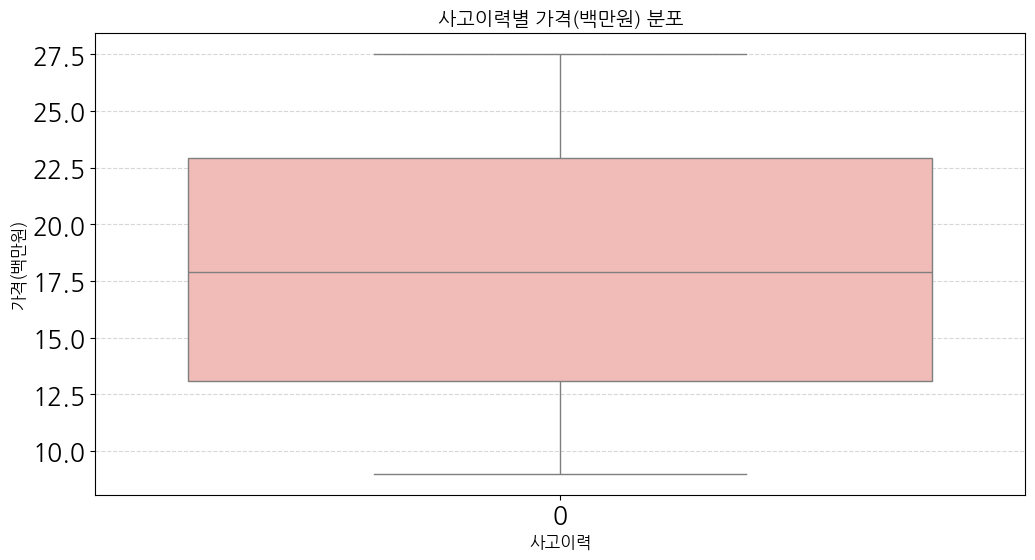

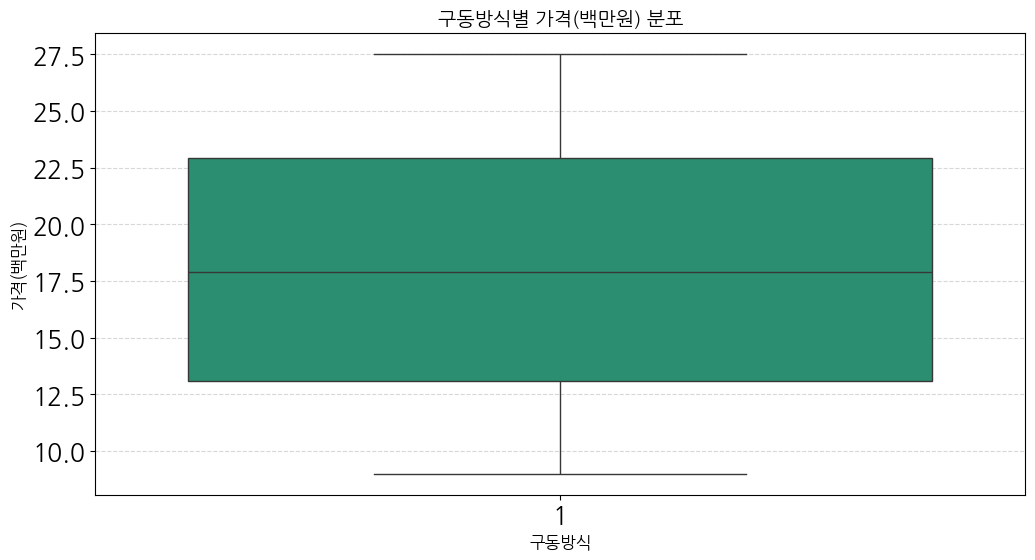

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

ioniq_data = train[train['모델'] == 4]

# 1. 차량상태와 가격(백만원) 비교
plt.figure(figsize=(12, 6))
sns.boxplot(data=ioniq_data, x='차량상태', y='가격(백만원)', palette='Set3')
plt.title('차량상태별 가격(백만원) 분포', fontsize=14)
plt.xlabel('차량상태', fontsize=12)
plt.ylabel('가격(백만원)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 2. 연식(년)과 가격(백만원) 비교
plt.figure(figsize=(12, 6))
sns.boxplot(data=ioniq_data, x='연식(년)', y='가격(백만원)', palette='Set2')
plt.title('연식(년)별 가격(백만원) 분포', fontsize=14)
plt.xlabel('연식(년)', fontsize=12)
plt.ylabel('가격(백만원)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 3. 보증기간(년)과 가격(백만원) 비교
plt.figure(figsize=(12, 6))
sns.boxplot(data=ioniq_data, x='보증기간(년)', y='가격(백만원)', palette='Set1')
plt.title('보증기간(년)별 가격(백만원) 분포', fontsize=14)
plt.xlabel('보증기간(년)', fontsize=12)
plt.ylabel('가격(백만원)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 4. 사고이력과 가격(백만원) 비교
plt.figure(figsize=(12, 6))
sns.boxplot(data=ioniq_data, x='사고이력', y='가격(백만원)', palette='Pastel1')
plt.title('사고이력별 가격(백만원) 분포', fontsize=14)
plt.xlabel('사고이력', fontsize=12)
plt.ylabel('가격(백만원)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 5. 구동방식과 가격(백만원) 비교
plt.figure(figsize=(12, 6))
sns.boxplot(data=ioniq_data, x='구동방식', y='가격(백만원)', palette='Dark2')
plt.title('구동방식별 가격(백만원) 분포', fontsize=14)
plt.xlabel('구동방식', fontsize=12)
plt.ylabel('가격(백만원)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [60]:
ioniq_data.describe()

,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
count,140.0,140.0,140.000000,108.000000,140.0,140.000000,140.000000,140.0,140.000000,140.000000
mean,2.0,4.0,1.528571,62.044352,1.0,47713.842857,1.978571,0.0,0.985714,17.991500
std,0.0,0.0,0.500975,10.958746,0.0,20193.625182,1.121842,0.0,0.856509,5.421621
min,2.0,4.0,1.000000,46.090000,1.0,10065.000000,1.000000,0.0,0.000000,9.000000
25%,2.0,4.0,1.000000,52.745000,1.0,30965.750000,1.000000,0.0,0.000000,13.110000
50%,2.0,4.0,2.000000,60.875000,1.0,47720.000000,1.000000,0.0,1.000000,17.895000
75%,2.0,4.0,2.000000,68.725000,1.0,66046.250000,3.000000,0.0,2.000000,22.942500
max,2.0,4.0,2.000000,88.080000,1.0,79763.000000,8.000000,0.0,2.000000,27.530000


In [61]:
ioniq_data['보증기간(년)'].value_counts()

,count
보증기간(년),
1,74
3,65
8,1


In [63]:
ioniq_min_max = ioniq_data.groupby('보증기간(년)')['가격(백만원)'].agg(['mean', 'std', 'min', 'max'])
ioniq_min_max

,mean,std,min,max
보증기간(년),,,,
1,17.349595,5.626801,9.00,27.42
3,18.755077,5.156284,9.00,27.53
8,15.860000,NaN,15.86,15.86


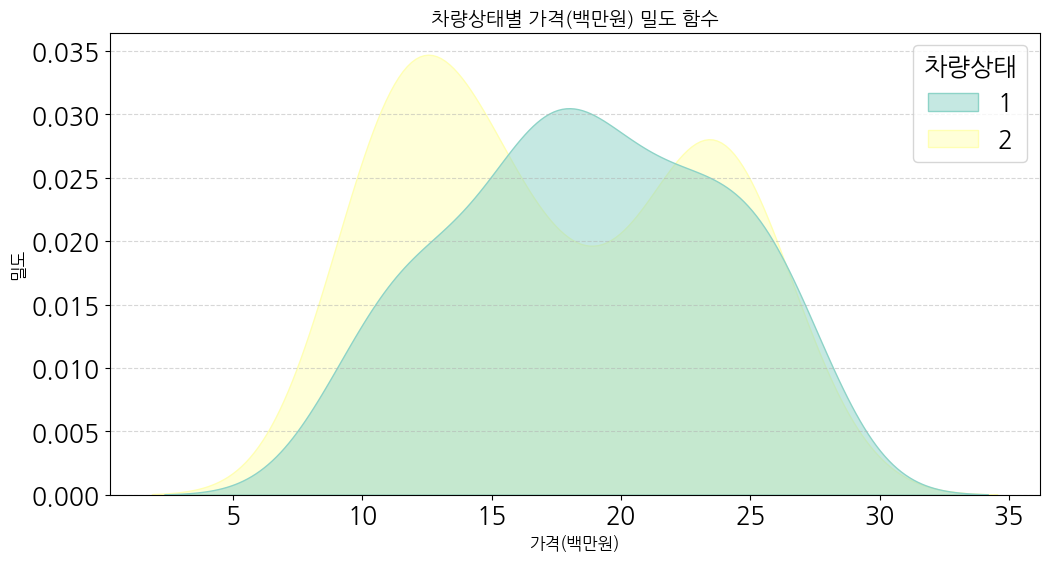

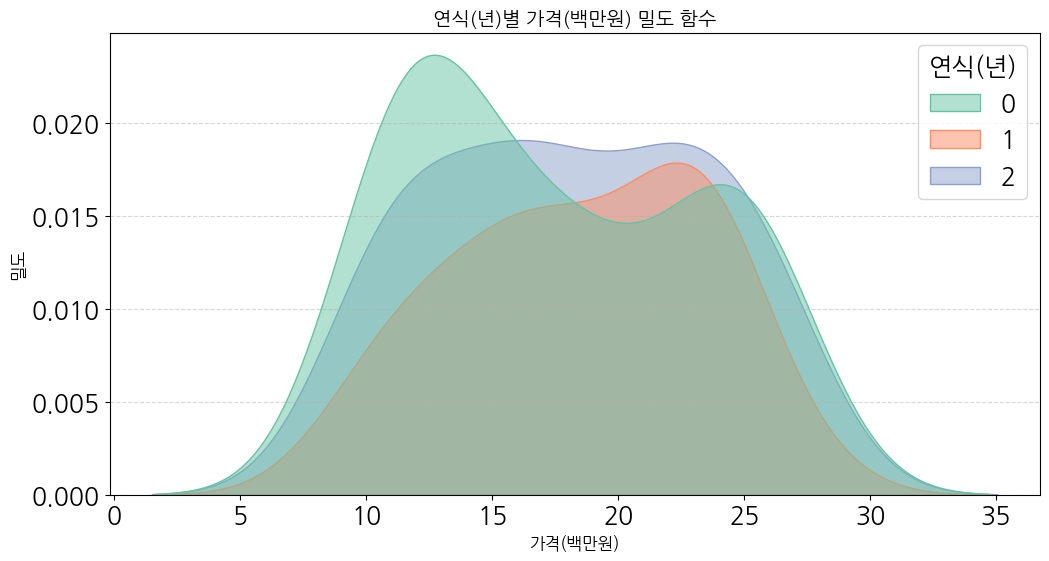

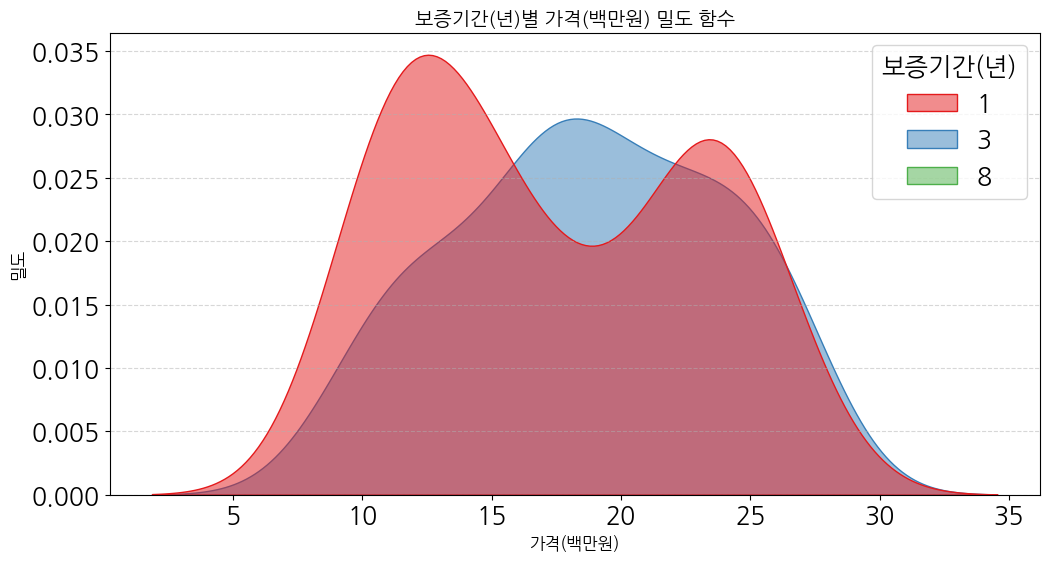

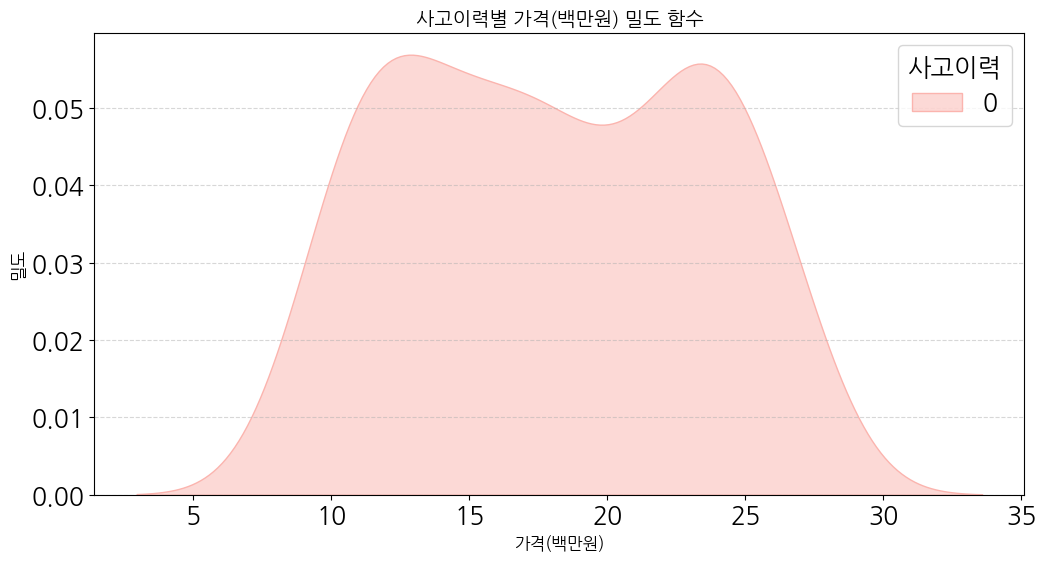

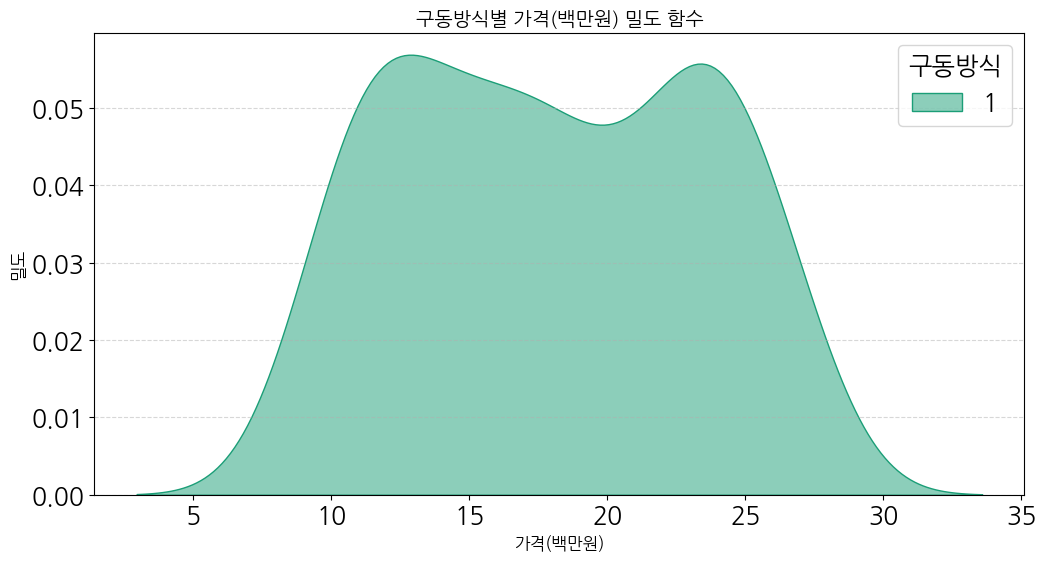

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

ioniq_data = train[train['모델'] == 4]

# 1. 차량상태와 가격(백만원) 비교 (밀도함수)
plt.figure(figsize=(12, 6))
sns.kdeplot(data=ioniq_data, x='가격(백만원)', hue='차량상태', fill=True, palette='Set3', alpha=0.5)
plt.title('차량상태별 가격(백만원) 밀도 함수', fontsize=14)
plt.xlabel('가격(백만원)', fontsize=12)
plt.ylabel('밀도', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 2. 연식(년)과 가격(백만원) 비교 (밀도함수)
plt.figure(figsize=(12, 6))
sns.kdeplot(data=ioniq_data, x='가격(백만원)', hue='연식(년)', fill=True, palette='Set2', alpha=0.5)
plt.title('연식(년)별 가격(백만원) 밀도 함수', fontsize=14)
plt.xlabel('가격(백만원)', fontsize=12)
plt.ylabel('밀도', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 3. 보증기간(년)과 가격(백만원) 비교 (밀도함수)
plt.figure(figsize=(12, 6))
sns.kdeplot(data=ioniq_data, x='가격(백만원)', hue='보증기간(년)', fill=True, palette='Set1', alpha=0.5)
plt.title('보증기간(년)별 가격(백만원) 밀도 함수', fontsize=14)
plt.xlabel('가격(백만원)', fontsize=12)
plt.ylabel('밀도', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 4. 사고이력과 가격(백만원) 비교 (밀도함수)
plt.figure(figsize=(12, 6))
sns.kdeplot(data=ioniq_data, x='가격(백만원)', hue='사고이력', fill=True, palette='Pastel1', alpha=0.5)
plt.title('사고이력별 가격(백만원) 밀도 함수', fontsize=14)
plt.xlabel('가격(백만원)', fontsize=12)
plt.ylabel('밀도', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 5. 구동방식과 가격(백만원) 비교 (밀도함수)
plt.figure(figsize=(12, 6))
sns.kdeplot(data=ioniq_data, x='가격(백만원)', hue='구동방식', fill=True, palette='Dark2', alpha=0.5)
plt.title('구동방식별 가격(백만원) 밀도 함수', fontsize=14)
plt.xlabel('가격(백만원)', fontsize=12)
plt.ylabel('밀도', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

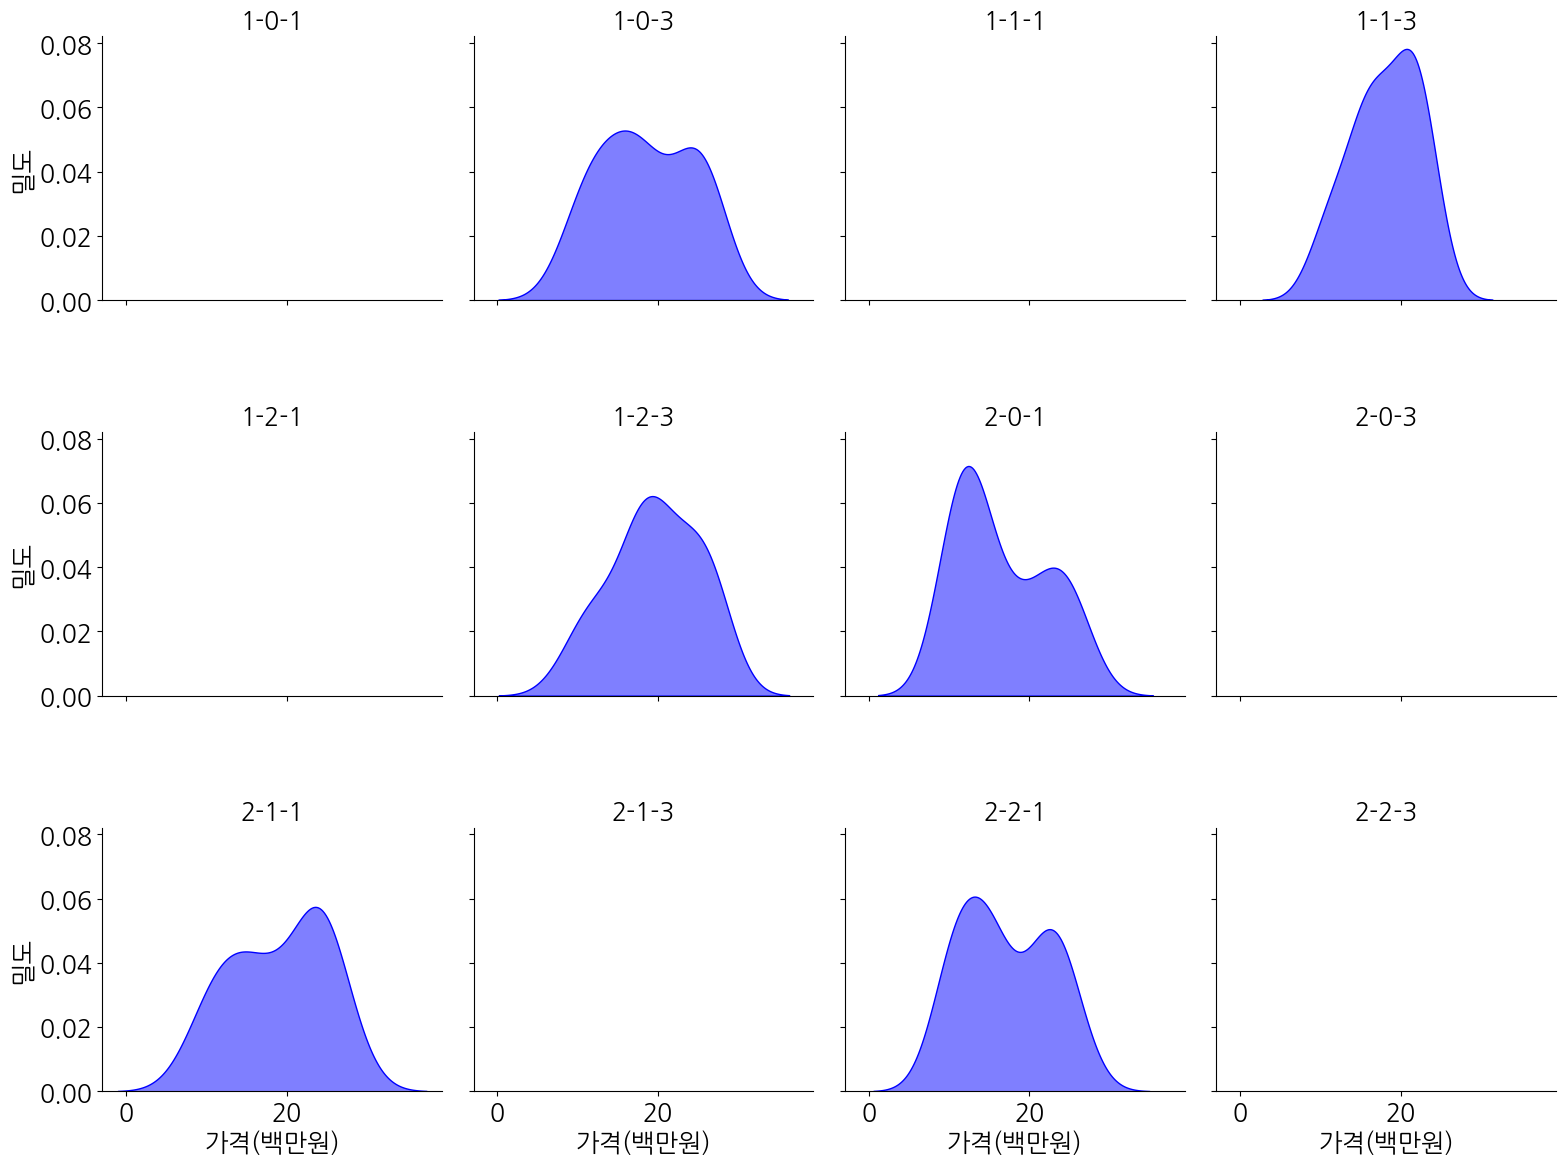

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a list of all possible combinations of '차량상태', '연식(년)', and '보증기간(년)'
vehicle_conditions = [1, 2]  # 차량상태
years = [0, 1, 2]  # 연식(년)
warranties = [1, 3]  # 보증기간(년)

# Generate all possible combinations
combinations = pd.MultiIndex.from_product([vehicle_conditions, years, warranties],
                                           names=["차량상태", "연식(년)", "보증기간(년)"])

# Create a new dataframe with these combinations
all_combinations = pd.DataFrame(index=combinations)

# Assuming 'train' is the dataframe and '모델' equals 4 (the filter for the specific model)
ioniq_data = train[train['모델'] == 4]

# Merge the original data with all possible combinations
merged_data = pd.merge(all_combinations, ioniq_data, how='left', on=['차량상태', '연식(년)', '보증기간(년)'])

# Create a new column combining the three variables for FacetGrid
merged_data['조합'] = (merged_data['차량상태'].astype(str) + '-' +
                       merged_data['연식(년)'].astype(str) + '-' +
                       merged_data['보증기간(년)'].astype(str))

# Set the figure size for the plot grid
g = sns.FacetGrid(merged_data, col="조합", col_wrap=4, height=4)

# Map the KDE plot to the grid
g.map(sns.kdeplot, '가격(백만원)', fill=True, color='b', alpha=0.5)

# Set titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("가격(백만원)", "밀도")

# Adjust the layout
plt.subplots_adjust(hspace=0.5)
plt.show()
# 차량상태 Mapping: 차량상태 - 연식 - 보증기간
# 'Brand New' -> 0
# 'Nearly New' -> 1
# 'Pre-Owned' -> 2

In [12]:
from scipy import stats

group_1_0_3 = merged_data[merged_data['조합'] == '1-0-3']['가격(백만원)'].dropna()
group_1_1_3 = merged_data[merged_data['조합'] == '1-1-3']['가격(백만원)'].dropna()
group_1_2_3 = merged_data[merged_data['조합'] == '1-2-3']['가격(백만원)'].dropna()
group_2_0_1 = merged_data[merged_data['조합'] == '2-0-1']['가격(백만원)'].dropna()
group_2_1_1 = merged_data[merged_data['조합'] == '2-1-1']['가격(백만원)'].dropna()
group_2_2_1 = merged_data[merged_data['조합'] == '2-2-1']['가격(백만원)'].dropna()

# 각 그룹별로 Shapiro-Wilk 검정 수행
stat_1_0_3, p_value_1_0_3 = stats.shapiro(group_1_0_3)
stat_1_1_3, p_value_1_1_3 = stats.shapiro(group_1_1_3)
stat_1_2_3, p_value_1_2_3 = stats.shapiro(group_1_2_3)
stat_2_0_1, p_value_2_0_1 = stats.shapiro(group_2_0_1)
stat_2_1_1, p_value_2_1_1 = stats.shapiro(group_2_1_1)
stat_2_2_1, p_value_2_2_1 = stats.shapiro(group_2_2_1)

print(f"1-0-3 그룹의 Shapiro-Wilk p-값: {p_value_1_0_3}")
print(f"1-1-3 그룹의 Shapiro-Wilk p-값: {p_value_1_1_3}")
print(f"1-2-3 그룹의 Shapiro-Wilk p-값: {p_value_1_2_3}")
print(f"2-0-1 그룹의 Shapiro-Wilk p-값: {p_value_2_0_1}")
print(f"2-1-1 그룹의 Shapiro-Wilk p-값: {p_value_2_1_1}")
print(f"2-2-1 그룹의 Shapiro-Wilk p-값: {p_value_2_2_1}")

1-0-3 그룹의 Shapiro-Wilk p-값: 0.11980112500839996
1-1-3 그룹의 Shapiro-Wilk p-값: 0.48434980032846214
1-2-3 그룹의 Shapiro-Wilk p-값: 0.37016946206084467
2-0-1 그룹의 Shapiro-Wilk p-값: 0.004467522109662694
2-1-1 그룹의 Shapiro-Wilk p-값: 0.11776589326940978
2-2-1 그룹의 Shapiro-Wilk p-값: 0.04283990449901352


In [13]:
levene_result = stats.levene(group_1_0_3, group_1_1_3, group_1_2_3, group_2_0_1, group_2_1_1, group_2_2_1)

print(f"Levene's 검정 통계량: {levene_result.statistic}")
print(f"Levene's p-값: {levene_result.pvalue}")

Levene's 검정 통계량: 0.6482152287447007
Levene's p-값: 0.6633308231070093


In [14]:
anova_result = stats.f_oneway(group_1_0_3, group_1_1_3, group_1_2_3, group_2_0_1, group_2_1_1, group_2_2_1)

print(f"ANOVA 통계량: {anova_result.statistic}")
print(f"ANOVA p-값: {anova_result.pvalue}")

ANOVA 통계량: 1.0937808411796257
ANOVA p-값: 0.3668610375027487


In [15]:
# Kruskal-Wallis 검정 수행
kruskal_result = stats.kruskal(group_1_0_3, group_1_1_3, group_1_2_3, group_2_0_1, group_2_1_1, group_2_2_1)

print(f"Kruskal-Wallis 통계량: {kruskal_result.statistic}")
print(f"Kruskal-Wallis p-값: {kruskal_result.pvalue}")

Kruskal-Wallis 통계량: 5.806131702209665
Kruskal-Wallis p-값: 0.3255425800656459


In [18]:
# 모든 그룹에 대해 로그 변환을 적용
group_1_0_3_log = np.log(group_1_0_3)
group_1_1_3_log = np.log(group_1_1_3)
group_1_2_3_log = np.log(group_1_2_3)
group_2_0_1_log = np.log(group_2_0_1)
group_2_1_1_log = np.log(group_2_1_1)
group_2_2_1_log = np.log(group_2_2_1)

# ANOVA 수행
anova_result = stats.f_oneway(group_1_0_3_log, group_1_1_3_log, group_1_2_3_log, group_2_0_1_log, group_2_1_1_log, group_2_2_1_log)

print(f"ANOVA 통계량: {anova_result.statistic}")
print(f"ANOVA p-값: {anova_result.pvalue}")

ANOVA 통계량: 1.1035262424460073
ANOVA p-값: 0.361605532029387


In [ ]:
# 배터리용량 , 주행거리 추가

In [24]:
train[(train['모델']==4) & (train['차량상태']==1) & (train['연식(년)']==0) & (train['보증기간(년)']==3)].sort_values(by='주행거리(km)',ascending=False)

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
1304,TRAIN_1304,2,4,1,86.68,1,76186,3,0,0,18.64
4522,TRAIN_4522,2,4,1,48.54,1,75270,3,0,0,25.06
143,TRAIN_0143,2,4,1,58.77,1,73469,3,0,0,24.04
5795,TRAIN_5795,2,4,1,57.83,1,72013,3,0,0,26.00
5240,TRAIN_5240,2,4,1,79.85,1,71522,3,0,0,24.27
62,TRAIN_0062,2,4,1,75.87,1,70822,3,0,0,11.12
2141,TRAIN_2141,2,4,1,NaN,1,70021,3,0,0,12.16
3880,TRAIN_3880,2,4,1,62.40,1,61383,3,0,0,25.06
5170,TRAIN_5170,2,4,1,NaN,1,54266,3,0,0,15.96
3485,TRAIN_3485,2,4,1,60.54,1,54246,3,0,0,11.99


In [33]:
train_103 = train[(train['모델']==4) & (train['차량상태']==1) & (train['연식(년)']==0) & (train['보증기간(년)']==3)]
train_103[train_103['가격(백만원)']>20].sort_values(by='가격(백만원)',ascending=False)

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
1662,TRAIN_1662,2,4,1,52.26,1,34409,3,0,0,26.95
2016,TRAIN_2016,2,4,1,65.21,1,44708,3,0,0,26.81
5795,TRAIN_5795,2,4,1,57.83,1,72013,3,0,0,26.00
3880,TRAIN_3880,2,4,1,62.40,1,61383,3,0,0,25.06
4522,TRAIN_4522,2,4,1,48.54,1,75270,3,0,0,25.06
5240,TRAIN_5240,2,4,1,79.85,1,71522,3,0,0,24.27
143,TRAIN_0143,2,4,1,58.77,1,73469,3,0,0,24.04
2440,TRAIN_2440,2,4,1,NaN,1,33527,3,0,0,23.60
6668,TRAIN_6668,2,4,1,58.29,1,20488,3,0,0,20.84


In [35]:
train_103[(train_103['가격(백만원)']<20) & (train_103['가격(백만원)']>14)].sort_values(by='가격(백만원)',ascending=False)

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
7050,TRAIN_7050,2,4,1,64.42,1,44255,3,0,0,19.00
1304,TRAIN_1304,2,4,1,86.68,1,76186,3,0,0,18.64
2680,TRAIN_2680,2,4,1,47.89,1,16568,3,0,0,17.96
5611,TRAIN_5611,2,4,1,86.02,1,38012,3,0,0,17.40
5527,TRAIN_5527,2,4,1,NaN,1,50652,3,0,0,17.21
5170,TRAIN_5170,2,4,1,NaN,1,54266,3,0,0,15.96
632,TRAIN_0632,2,4,1,46.13,1,29087,3,0,0,15.00
7252,TRAIN_7252,2,4,1,59.64,1,45794,3,0,0,14.52


In [36]:
train_103[train_103['가격(백만원)']<14].sort_values(by='가격(백만원)',ascending=False)

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
6300,TRAIN_6300,2,4,1,NaN,1,45873,3,0,0,13.55
2141,TRAIN_2141,2,4,1,NaN,1,70021,3,0,0,12.16
3485,TRAIN_3485,2,4,1,60.54,1,54246,3,0,0,11.99
62,TRAIN_0062,2,4,1,75.87,1,70822,3,0,0,11.12
1143,TRAIN_1143,2,4,1,NaN,1,47892,3,0,0,9.92
4118,TRAIN_4118,2,4,1,62.81,1,40675,3,0,0,9.38
